# **Model Testing** - Word Modeling

Testing models on titles only.

# **Query Data**

In [1]:
pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in /Users/melissamunz/anaconda3/lib/python3.7/site-packages (0.2.5)
Note: you may need to restart the kernel to use updated packages.


In [87]:
import mysql.connector 
import numpy as np
import pandas as pd
import requests

from sodapy import Socrata
import sqlalchemy as db

import config_final as config
from schema import DbSchema

import pickle


In [88]:
bills_db = DbSchema(config)

# topics_db = bills_db.query('SELECT * from topics')

In [89]:
#Query all titles and Passing

df = bills_db.query("""
    SELECT
        cb.Title,
        cb.PassH
    FROM con_bills.current_bills as cb
    JOIN con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE cb.Cong >=110
    """)
df.head()

,Title,PassH
0,To provide for the implementation of the recom...,1
1,Reserved for Speaker.,0
2,To amend the Higher Education Act of 1965 to p...,0
3,To award a congressional gold medal to Edward ...,0
4,To amend the Haitian Hemispheric Opportunity t...,0


In [90]:
df.shape

(51067, 2)

In [91]:
# df.groupby(['dominant_topic', 'PassH']).size()

In [92]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

# **Tokenizer:**

In [93]:
nlp = English()

stop_words = spacy.lang.en.stop_words.STOP_WORDS

nlp.Defaults.stop_words |= {"bill","amend", "purpose", "united", "state", "states", "secretary", "act", "federal", "provide"}

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')

stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [94]:
import spacy
from spacy.lang.en import English
import en_core_web_sm
import string
import re

def tokenizer(text):
    
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #MAP SPECIFIC WORDS to others (veteran from veterans)

    #add stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens
    

In [95]:
# df['Title'] = df['Title'].apply(tokenizer)
# df.head()


In [128]:
df['tokenized_title']=df['Title'].apply(lambda x: tokenizer(x))

In [129]:
df.head()

,Title,PassH,tokenized_title
0,To provide for the implementation of the recom...,1,"[implementation, recommendation, national, com..."
1,Reserved for Speaker.,0,"[reserve, speaker]"
2,To amend the Higher Education Act of 1965 to p...,0,"[high, education, prevent, veteran, contributi..."
3,To award a congressional gold medal to Edward ...,0,"[award, congressional, gold, medal, edward, wi..."
4,To amend the Haitian Hemispheric Opportunity t...,0,"[haitian, hemispheric, opportunity, partnershi..."


In [279]:
for_pickle = df.drop(columns='Title')

In [280]:

#is it vectorizer or transformed?
tk_titles = 'tokenized_titles.sav'
pickle.dump(for_pickle, open(tk_titles, 'wb'))
 

In [1]:
# load the model from disk
test_1 = pickle.load(open(tk_titles, 'rb'))
test_1.head()

NameError: name 'pickle' is not defined

# **Train and Test**

In [254]:
from sklearn.model_selection import train_test_split

X = df['tokenized_title']
y = df['PassH']


In [255]:
X.head()


0    [implementation, recommendation, national, com...
1                                   [reserve, speaker]
2    [high, education, prevent, veteran, contributi...
3    [award, congressional, gold, medal, edward, wi...
4    [haitian, hemispheric, opportunity, partnershi...
Name: tokenized_title, dtype: object

# **Modeling**

Import packages:

- CountVectorizer
- TFIDF

- Naive Bayes
- Logistic Regression
- Random Forest

**Remember to look at feature importances!

In [256]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import FeatureHasher


**Train test split**

In [257]:
#Train Test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1)

In [258]:
X_train.head()

1638     [food, security, encourage, owner, operator, p...
13956    [food, nutrition, reduce, interval, issuance, ...
24981              [suspend, temporarily, duty, acid, red]
45850                          [fund, chicago, university]
44998    [require, governor, submit, attorney, general,...
Name: tokenized_title, dtype: object

In [259]:
X_train.shape

(40853,)

**Sentence Embeddings**

In [260]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('bert-base-nli-mean-tokens')

In [261]:
# sentence_embeddings_train = model.encode(X_train)
# sentence_embeddings_test = model.encode(X_test)

**Naive Bayes**

# **Logistic Regression**

- Precision means the percentage of your results which are relevant. 
- recall refers to the percentage of total relevant results correctly classified by your algorithm.

Also make a precision recall curve

# Count Vectorizer

In [266]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer1 = CountVectorizer(tokenizer = tokenizer, max_df = 0.90, max_features = 10000) # max_df=0.90, min_df=10
trainsformed = vectorizer1.fit_transform(X_train, X_test)

print(len(vectorizer1.get_feature_names()))

# vectorizer = CountVectorizer(tokenizer=tokenizer, max_df=0.5, max_features=None)

# transformed = c_vectorizer.fit_transform(X_train, y_train)

AttributeError: 'list' object has no attribute 'lower'

Using Pipeline:

In [267]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Bring in OHE?
def dummy(doc):
    return doc

lr_clf = Pipeline([('vect', CountVectorizer(tokenizer = dummy, preprocessor = dummy, max_df=0.5, max_features=None)),
               ('clf', LogisticRegression(class_weight='balanced', C=.8)),
              ])

# Logistic Regression Classifier

# lr_clf = LogisticRegression(class_weight='balanced', C=.8)

lr_clf.fit(X_train, y_train)

lr_y_pred = lr_clf.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred))
print(classification_report(y_test, lr_y_pred))

lr_confusion_matrix = confusion_matrix(y_test, lr_y_pred)

[[7654 1734]
 [ 349  477]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      9388
           1       0.22      0.58      0.31       826

    accuracy                           0.80     10214
   macro avg       0.59      0.70      0.60     10214
weighted avg       0.90      0.80      0.83     10214



/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [242]:
# save the model to disk
lr_word_model = 'finalized_logistic_regression_word_model.sav'
pickle.dump(lr_clf, open(lr_word_model, 'wb'))
 
# some time later...


In [157]:
# load the model from disk
Final_Model = pickle.load(open(lr_word_model, 'rb'))


In [247]:
test_ = Final_Model.predict(['national, implement, forest, veteran'])

In [248]:
test_

array([0])

# TFIDF Test:

In [268]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Bring in OHE?

lr_clf_tf = Pipeline([('vect', TfidfVectorizer(tokenizer=dummy, preprocessor = dummy, encoding='utf-8', smooth_idf = True)),
               ('clf', LogisticRegression(class_weight='balanced', C=.8)),
              ])

# Logistic Regression Classifier
# lr_classifier = LogisticRegression()

lr_clf_tf.fit(X_train, y_train)

lr_y_pred_tf = lr_clf_tf.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred_tf))
print(classification_report(y_test, lr_y_pred_tf))

lr_confusion_matrix = confusion_matrix(y_test, lr_y_pred_tf)

[[7419 1969]
 [ 308  518]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      9388
           1       0.21      0.63      0.31       826

    accuracy                           0.78     10214
   macro avg       0.58      0.71      0.59     10214
weighted avg       0.90      0.78      0.82     10214



In [273]:
test_2 = lr_clf_tf.predict(['A bill to designate postal office post office for forests in a forest of national veterans'])

In [274]:
test_2

array([0])

Text(0.5, 1, 'Confusion Matrix')

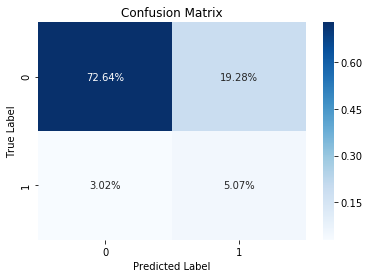

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(lr_confusion_matrix/np.sum(lr_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [224]:
#for ROC/AUC Curve

lr_dec = lr_clf.decision_function(X_test)

import numpy as np
from sklearn.metrics import roc_auc_score
lr_roc_auc = roc_auc_score(y_test, lr_y_pred)
lr_roc_auc

#This is a decent ROC Score. Remember lays between .5 and 1

0.6963889814517734

Test AUC: 0.7688534691136281


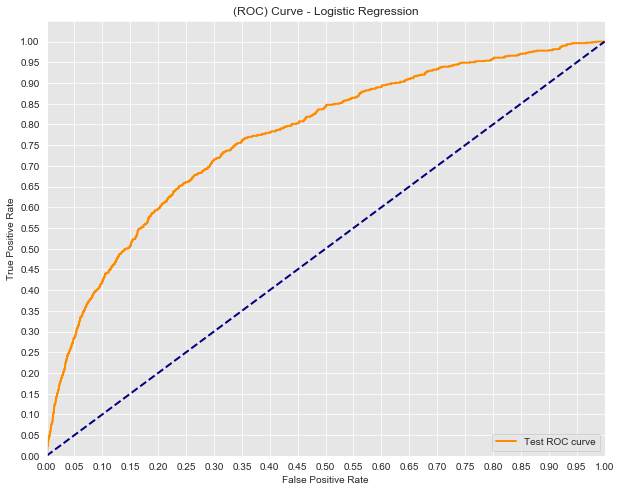

In [225]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, lr_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [226]:
from sklearn.metrics import average_precision_score

lr_average_precision = average_precision_score(y_test, lr_dec)

print('Average precision-recall score: {0:0.2f}'.format(
      lr_average_precision))

Average precision-recall score: 0.26


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.26')

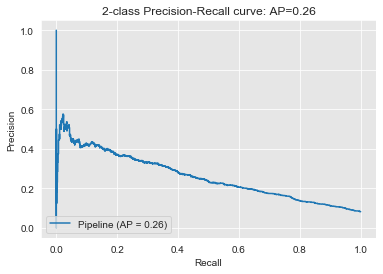

In [227]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lr_clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(lr_average_precision))

Evaluate:
- ROC/AUC

# **Random Forest**

Class Imbalance: To overcome this issue, we used repeated random sub-sampling. Initially, we construct the testing data and the NoS training data sub-samples. For each disease, we train NoS classifiers and test all of them on the same data set. The final labels of the testing data are computed using a majority voting scheme.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#add bag of trees?
#add OHE

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=None, max_features='auto', n_estimators=10, class_weight="balanced"))])


rf_pipeline.fit(X_train, y_train) 

rf_y_pred = rf_pipeline.predict(X_test)

print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

rf_confusion_matrix = confusion_matrix(y_test, rf_y_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(rf_confusion_matrix/np.sum(rf_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [ ]:
feature_names = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

In [ ]:
importances = rf_pipeline.steps[1][1].feature_importances_
len(importances)

In [ ]:
indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]

In [ ]:
new_indices

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
#     n_features = importances.shape
    
    plt.figure(figsize=(15,200))
    plt.barh(range(1044), importances, align='center') 
    
    plt.yticks(np.arange(1044), feature_names) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf_pipeline)